<a href="https://colab.research.google.com/github/LeraUseinova/SmokeDetection/blob/main/SmokeRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset/Datasets.zip -d /content/dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/Датасет/train/Cloud/cloud_374.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_375.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_376.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_377.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_378.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_379.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_38.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_380.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_381.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_382.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_383.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_384.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_385.tif  
  inflating: /content/dataset/Датасет/train/Cloud/cloud_386.tif  
  inflati

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 20.3 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch.nn as nn
import torchvision.models as models
from collections import OrderedDict
from torchvision.models.resnet import BasicBlock
from torchvision.models.resnet import Bottleneck
import torchmetrics
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix

In [ ]:
# Гиперпараметры
num_epochs = 100
num_classes = 6
batch_size = 32
learning_rate = 0.001
weight_decay = 0.0001

# Конфигурация устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Пути к папкам с данными
train_dir = "/content/dataset/Датасет/train"
val_dir = "/content/dataset/Датасет/validation"
test_dir = "/content/dataset/Датасет/test"

In [ ]:
"""
Вычисление среднего и стандартного отклонения по тренировочному датасету 
""" 


dataset = datasets.ImageFolder(train_dir, transform=transforms.ToTensor())
loader = DataLoader(dataset, batch_size=batch_size,num_workers=2)

def mean_std(loader):
    
    cnt = 0
    fst_moment = torch.empty(3, dtype=torch.float32)
    snd_moment = torch.empty(3, dtype=torch.float32)

    with torch.no_grad():
      for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3], dtype=torch.float32)
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3], dtype=torch.float32)
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)       
    return mean,std

mean, std = mean_std(loader)
print("mean and std: \n",mean, std)

mean and std: 
 tensor([0.2936, 0.2801, 0.2721]) tensor([0.2273, 0.2173, 0.2131])


In [ ]:
"""
 Преобразование изображений
"""

data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Загрузка датасетов
train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Определяем загрузчики данных
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

classes = train_dataset.classes

print('Classes: ',  classes)
print('The train dataset have: ',  len(train_dataset) ," images.")
print('Number of train downloaded images per batch: ',  len(train_dataloader))
print('The valid dataset have: ',  len(val_dataset)," images.")
print('Number of valid downloaded images per batch: ',  len(val_dataloader))
print('The test dataset have: ', len(test_dataset) ," images.")
print('Number of test downloaded images per batch: ',  len(test_dataloader))


Classes:  ['Cloud', 'Dust', 'Haze', 'Land', 'Seaside', 'Smoke']
The train dataset have:  4357  images.
Number of train downloaded images per batch:  137
The valid dataset have:  936  images.
Number of valid downloaded images per batch:  30
The test dataset have:  932  images.
Number of test downloaded images per batch:  30


In [ ]:
"""
Вычисление среднего и стандартного отклонения после преобразования
"""

mean_normal, std_normal = mean_std(train_dataloader)
print("mean and std after normalize:\n",
      mean_normal, std_normal)

mean and std after normalize:
 tensor([0.0191, 0.0245, 0.0271]) tensor([0.9912, 0.9907, 0.9882])


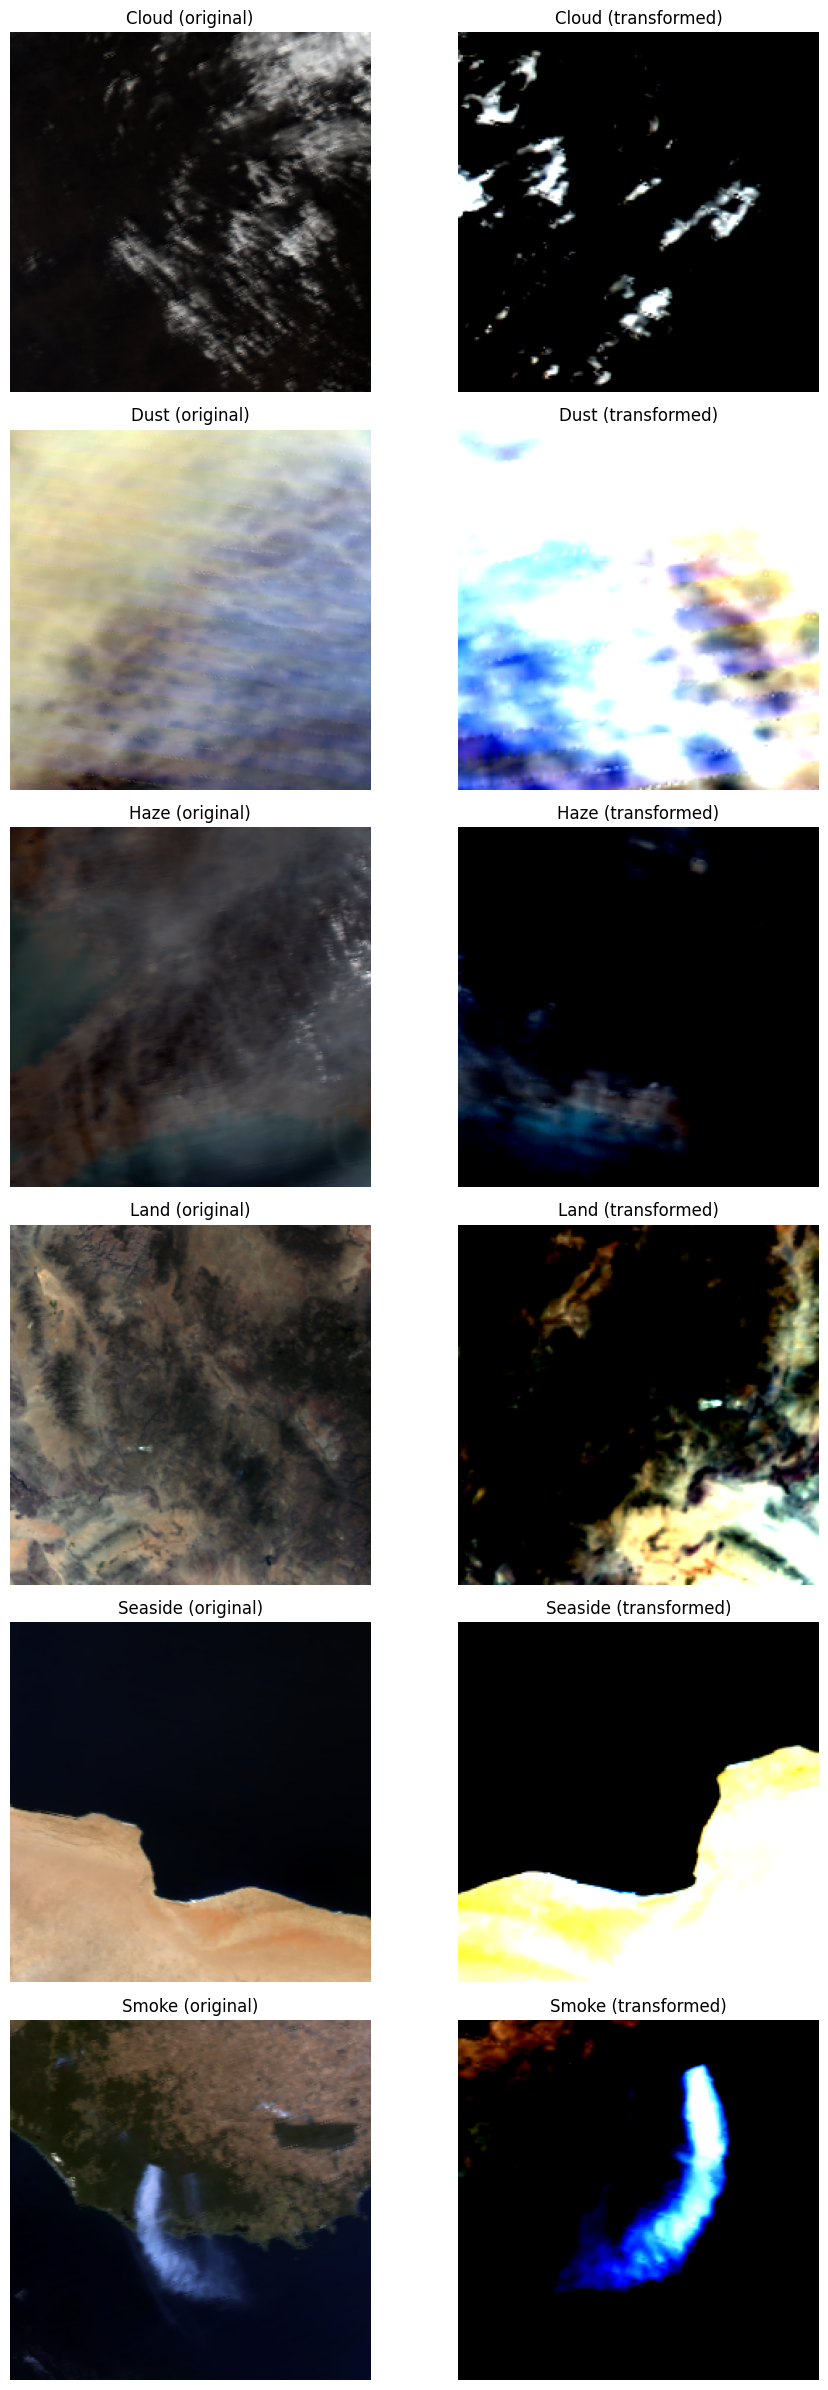

In [ ]:
"""
Вывод изображений до и после преобразования
"""

original_dataset = ImageFolder(train_dir)

# Вывод по одной случайной картинке из каждого класса, после преобразований
fig, axes = plt.subplots(nrows=len(original_dataset.class_to_idx), ncols=2, figsize=(10, 4 * len(original_dataset.class_to_idx)))

for i, (class_name, class_idx) in enumerate(original_dataset.class_to_idx.items()):
    # Извлечение всех изображений данного класса
    images = original_dataset.imgs
    class_images = [img[0] for img in images if img[1] == class_idx]

    # Выбор случайного изображения из данного класса
    torch.manual_seed(123)
    random_image_path = random.sample(class_images, 1)[0]
    image = Image.open(random_image_path)

    # Применение преобразований к изображению
    transformed_image = data_transform(image)

    # Вывод изображений до и после преобразований
    axes[i][0].imshow(image)
    axes[i][0].set_title(f'{class_name} (original)')
    axes[i][0].axis("off")
    axes[i][1].imshow(transformed_image.permute(1, 2, 0))
    axes[i][1].set_title(f'{class_name} (transformed)')
    axes[i][1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
"""
Добавляем к предобученной модели дропаут 
"""
model = models.resnet18(pretrained=True)

# Замена последнего слоя на новый слой с dropout и с своим количеством классов
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, num_classes)
)

# Перемещение модели на GPU
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
"""
Добавляем к предобученной модели дропаут и механизмы внимания
"""

class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, 1, kernel_size=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.avg_pool(x)
        avg_out = self.conv1(avg_out)
        avg_out = self.conv2(avg_out)
        max_out = self.max_pool(x)
        max_out = self.conv1(max_out)
        max_out = self.conv2(max_out)
        out = torch.cat([avg_out, max_out], dim=1)
        mask = self.sigmoid(out)
        return x * mask

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)
        avg_out = self.fc2(self.relu(self.fc1(avg_pool)))
        max_out = self.fc2(self.relu(self.fc1(max_pool)))
        x = avg_out + max_out
        x = self.sigmoid(x)
        return x


class ResNetWithAttention(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNetWithAttention, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Add channel attention and spatial attention modules to each residual block
        for module in self.resnet.modules():
            if isinstance(module, nn.Sequential):
                for i in range(len(module)):
                    if isinstance(module[i], BasicBlock):
                        module[i].ca = ChannelAttention(module[i].conv2.out_channels)
                        module[i].sa = SpatialAttention(module[i].conv2.in_channels)
                    elif isinstance(module[i], Bottleneck):
                        module[i].ca = ChannelAttention(module[i].conv3.out_channels)
                        module[i].sa = SpatialAttention(module[i].conv3.in_channels)

        # Replace the final fully connected layer to output 6 classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.resnet.fc(x)

        return x

model = ResNetWithAttention()
            
# Перемещение модели на GPU
model.to(device)

ResNetWithAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [ ]:
"""
Обучаем модель
"""
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Код для обучения модели
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(num_epochs):
    # Обучение модели на тренировочном датасете
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_dataloader:
        # Перемещаем тензоры на устройство
        images = images.to(device)
        labels = labels.to(device)

        # Прямое прохождение 
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Добавление регуляризации
        for name, param in model.named_parameters():
            if 'weight' in name:
                l2_regularization = torch.norm(param)
                loss += weight_decay * l2_regularization

        # Обратное прхождение и оптимизация              
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Очищаем память на устройстве
        del images, labels, outputs
        torch.cuda.empty_cache()

    epoch_train_loss = running_loss / len(train_dataloader.dataset)
    epoch_train_acc = 100 * correct / total
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    # Проверка модели на валидационном датасете
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Очищаем память на устройстве
            del images, labels, outputs
            torch.cuda.empty_cache()

    epoch_val_loss = running_loss / len(val_dataloader.dataset)
    epoch_val_acc = 100 * correct / total
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'.format(epoch+1, num_epochs, epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc))
    
    # Сохраняем модель с лучшей точностью
    best_acc = 0
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save({
            'model': model,
            'state_dict': model.state_dict()
            }, '/content/resnet50_model_with_dropout_2.pth')

    # Уменьшаем learning rate, если в течение 5 эпох точность не улучшается
    scheduler.step(epoch_val_loss)
    
    # Останавливаем обучение, если в течение 10 эпох точность не улучшается
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Построение графиков
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(train_loss, label='train')
ax[0].plot(val_loss, label='validation')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(train_acc, label='train')
ax[1].plot(val_acc, label='validation')
ax[1].set_title('Accuracy')
ax[1].legend()

Epoch [1/100], Train Loss: 1.1125, Train Acc: 64.38%, Val Loss: 0.7017, Val Acc: 76.39%
Epoch [2/100], Train Loss: 0.8284, Train Acc: 73.81%, Val Loss: 0.7810, Val Acc: 72.76%
Epoch [3/100], Train Loss: 0.7796, Train Acc: 75.53%, Val Loss: 0.7984, Val Acc: 75.53%
Epoch [4/100], Train Loss: 0.7006, Train Acc: 78.54%, Val Loss: 0.3596, Val Acc: 88.57%
Epoch [5/100], Train Loss: 0.6588, Train Acc: 79.73%, Val Loss: 0.4646, Val Acc: 85.47%
Epoch [6/100], Train Loss: 0.7874, Train Acc: 74.89%, Val Loss: 0.5410, Val Acc: 82.91%
Epoch [7/100], Train Loss: 0.6637, Train Acc: 80.12%, Val Loss: 0.5938, Val Acc: 80.34%
Epoch [8/100], Train Loss: 0.6450, Train Acc: 79.62%, Val Loss: 0.4390, Val Acc: 87.61%
Epoch [9/100], Train Loss: 0.5983, Train Acc: 82.65%, Val Loss: 0.3820, Val Acc: 85.36%
Epoch [10/100], Train Loss: 0.5465, Train Acc: 83.59%, Val Loss: 0.4149, Val Acc: 85.90%
Epoch [11/100], Train Loss: 0.4831, Train Acc: 85.93%, Val Loss: 0.2657, Val Acc: 90.60%
Epoch [12/100], Train Loss: 0.

In [ ]:
"""
Тестируем модель
"""
# Загружаем модель
checkpoint = torch.load('/content/resnet50.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

# Загрузка предобученной модели 
#model = models.resnet18(pretrained=True)

# Замена последнего слоя (fc) на новый слой с 6 выходными нейронами
#num_ftrs = model.fc.in_features
#model.fc = torch.nn.Linear(num_ftrs, 6)

# Загрузка сохраненных весов
#model.load_state_dict(torch.load('/content/resnet18_model_with_attention_after_downsample.pth'))

# Перемещение модели на устройство
model = model.to(device)

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_dataloader:
        # Перемещаем тензоры на устройство
        images = images.to(device)
        labels = labels.to(device)

        # Получаем прогнозы модели 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Вычисляем колличество правильных предсказаний
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = torchmetrics.functional.accuracy(torch.tensor(y_pred), torch.tensor(y_true), num_classes=num_classes, task='multiclass')
precision = torchmetrics.functional.precision(torch.tensor(y_pred), torch.tensor(y_true), num_classes=num_classes, average='macro', task='multiclass')
recall = torchmetrics.functional.recall(torch.tensor(y_pred), torch.tensor(y_true), num_classes=num_classes, average='macro', task='multiclass')
f1 = f1_score(y_true, y_pred, average='macro')

print('Accuracy: {:.4f}%, Precision: {:.4f}, Recall: {:.4f}, F1 score: {:.4f}'.format(accuracy * 100, precision, recall, f1))

# Строим матрицу ошибок
cm = confusion_matrix(y_true, y_pred)
print("confusion matrix: \n", cm)


Accuracy: 95.1717%, Precision: 0.9516, Recall: 0.9505, F1 score: 0.9506
confusion matrix: 
 [[173   0   0   0   0   1]
 [  0 145   3   2   0   1]
 [  1   8 132   1   1   7]
 [  0   2   0 152   0   0]
 [  2   1   0   2 143   3]
 [  1   2   4   3   0 142]]
